# Model 1A — Traditional ML — Time-Aware Failure Classification

This notebook trains a traditional machine learning model using **time-aware features** derived from sensor readings.

Project context:
- Dataset: AI4I 2020 Predictive Maintenance (industrial sensor snapshots)
- Time proxy: `Tool wear [min]` is treated as progression over time-under-use
- Goal (Model 1): Predict **failure risk** as tool wear increases using traditional ML (baseline + tree-based)

Notes:
- We split train/test **by time order** (no shuffle).
- We avoid label leakage by excluding the failure-mode flags when predicting `Machine failure`.


### 1. Import & Setup

In [1]:
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    average_precision_score,
    RocCurveDisplay,
    PrecisionRecallDisplay
)

import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)

### 2. Load prepared data

We prefer using the exported prepared dataset from the EDA notebook (`data/ai4i_prepared.csv`).
If it is not available, we load the raw dataset and apply minimal preprocessing:
- Drop identifiers (`UDI`, `Product ID`)
- Drop failure-mode flags (`TWF`, `HDF`, `PWF`, `OSF`, `RNF`) to avoid leakage when predicting `Machine failure`
- One-hot encode `Type`

In [2]:
DATA_PREPARED_PATH = "../data/ai4i_prepared.csv"
DATA_RAW_PATH = "../data/ai4i_2020_predictive_maintenance.csv"

TARGET_COL = "Machine failure"
TIME_COL = "Tool wear [min]"

def load_dataset():
    if os.path.exists(DATA_PREPARED_PATH):
        df = pd.read_csv(DATA_PREPARED_PATH)
        source = "prepared"
    else:
        df_raw = pd.read_csv(DATA_RAW_PATH)
        drop_cols = ["UDI", "Product ID", "TWF", "HDF", "PWF", "OSF", "RNF"]
        df = df_raw.drop(columns=[c for c in drop_cols if c in df_raw.columns], errors="ignore")
        if "Type" in df.columns:
            df = pd.get_dummies(df, columns=["Type"], drop_first=True)
        source = "raw+prepped"
    return df, source

df, source = load_dataset()
print(f"Loaded source: {source}")
print("Shape:", df.shape)
df.head()

Loaded source: prepared
Shape: (10000, 14)


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,7257,H36670,H,300.2,310.3,1408,42.5,0,0,0,0,0,0,0
2,504,M15363,M,297.6,309.2,1442,48.1,0,0,0,0,0,0,0
3,7169,L54348,L,300.3,310.3,1704,29.5,0,0,0,0,0,0,0
4,7089,M21948,M,300.6,310.3,1614,32.7,0,0,0,0,0,0,0


### 3. Validate required columns

In [3]:
sensor_cols = [
    "Air temperature [K]",
    "Process temperature [K]",
    "Rotational speed [rpm]",
    "Torque [Nm]",
    TIME_COL,
    TARGET_COL
]

missing = [c for c in sensor_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

print("All required columns are present.")

All required columns are present.


### 4. Time-aware feature engineering

Because AI4I is not a per-machine chronological log, we use a **population-level** time proxy:
- Sort by `Tool wear [min]`
- Aggregate to a single series over tool wear (mean of numeric features)
- Create lag, rolling mean, rolling std, and deltas to capture change over time

This creates a clean, ordered sequence suitable for traditional time-series style modeling.


In [4]:
df_tw = (
    df
    .groupby(TIME_COL, as_index=False)
    .agg({
        "Air temperature [K]": "mean",
        "Process temperature [K]": "mean",
        "Rotational speed [rpm]": "mean",
        "Torque [Nm]": "mean",
        TARGET_COL: "max",
    })
    .sort_values(TIME_COL)
    .reset_index(drop=True)
)

print("Aggregated shape:", df_tw.shape)
print("Label distribution after aggregation:")
print(df_tw[TARGET_COL].value_counts())
df_tw.head()

Aggregated shape: (246, 6)
Label distribution after aggregation:
Machine failure
1    172
0     74
Name: count, dtype: int64


,Tool wear [min],Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Machine failure
0,0,299.956667,309.955833,1524.916667,40.661667,1
1,2,300.272464,310.142029,1555.521739,39.646377,1
2,3,299.679412,309.826471,1508.264706,41.644118,1
3,4,299.997059,309.870588,1525.882353,41.117647,0
4,5,299.925397,310.014286,1620.761905,36.071429,1


### 5. Create time-aware features (lags, rolling stats, deltas)

We create features that depend only on past values:
- Lag features
- Rolling mean/std (past-only)
- First differences (deltas)

In [5]:
def make_time_features(
    df_time: pd.DataFrame,
    base_cols,
    time_col: str,
    target_col: str,
    windows=(3, 5, 10),
    lags=(1, 2, 3),
):
    # Avoid duplicate column names if time_col accidentally appears in base_cols
    base_cols = [c for c in base_cols if c != time_col and c != target_col]

    df_feat = df_time[[time_col] + base_cols + [target_col]].copy()

    # Lag features
    for lag in lags:
        for c in base_cols:
            df_feat[f"{c}__lag{lag}"] = df_feat[c].shift(lag)

    # Rolling stats (past-only)
    for w in windows:
        for c in base_cols:
            df_feat[f"{c}__roll{w}_mean"] = (
                df_feat[c].shift(1).rolling(window=w, min_periods=w).mean()
            )
            df_feat[f"{c}__roll{w}_std"] = (
                df_feat[c].shift(1).rolling(window=w, min_periods=w).std()
            )

    # Deltas
    for c in base_cols:
        df_feat[f"{c}__delta1"] = df_feat[c].diff(1)

    df_feat = df_feat.dropna().reset_index(drop=True)
    return df_feat


base_feature_cols = [
    "Air temperature [K]",
    "Process temperature [K]",
    "Rotational speed [rpm]",
    "Torque [Nm]",
]

df_feat = make_time_features(
    df_tw,
    base_cols=base_feature_cols,
    time_col=TIME_COL,
    target_col=TARGET_COL,
    windows=(3, 5, 10),
    lags=(1, 2, 3),
)

print("Feature-engineered shape:", df_feat.shape)
print("Label distribution after feature engineering:")
print(df_feat[TARGET_COL].value_counts())
df_feat.head()

Feature-engineered shape: (236, 46)
Label distribution after feature engineering:
Machine failure
1    164
0     72
Name: count, dtype: int64


,Tool wear [min],Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Machine failure,Air temperature [K]__lag1,Process temperature [K]__lag1,Rotational speed [rpm]__lag1,Torque [Nm]__lag1,Air temperature [K]__lag2,Process temperature [K]__lag2,Rotational speed [rpm]__lag2,Torque [Nm]__lag2,Air temperature [K]__lag3,Process temperature [K]__lag3,Rotational speed [rpm]__lag3,Torque [Nm]__lag3,Air temperature [K]__roll3_mean,Air temperature [K]__roll3_std,Process temperature [K]__roll3_mean,Process temperature [K]__roll3_std,Rotational speed [rpm]__roll3_mean,Rotational speed [rpm]__roll3_std,Torque [Nm]__roll3_mean,Torque [Nm]__roll3_std,Air temperature [K]__roll5_mean,Air temperature [K]__roll5_std,Process temperature [K]__roll5_mean,Process temperature [K]__roll5_std,Rotational speed [rpm]__roll5_mean,Rotational speed [rpm]__roll5_std,Torque [Nm]__roll5_mean,Torque [Nm]__roll5_std,Air temperature [K]__roll10_mean,Air temperature [K]__roll10_std,Process temperature [K]__roll10_mean,Process temperature [K]__roll10_std,Rotational speed [rpm]__roll10_mean,Rotational speed [rpm]__roll10_std,Torque [Nm]__roll10_mean,Torque [Nm]__roll10_std,Air temperature [K]__delta1,Process temperature [K]__delta1,Rotational speed [rpm]__delta1,Torque [Nm]__delta1
0,11,300.000000,309.876190,1505.285714,41.078571,1,300.148889,310.191111,1515.666667,42.362222,300.196364,310.089091,1547.781818,39.861818,299.888889,309.827778,1513.111111,42.172222,300.078047,0.165527,310.035993,0.187396,1525.519865,19.321714,41.465421,1.392006,300.014826,0.190990,309.978036,0.225854,1530.775323,17.056630,40.777195,1.558879,299.990513,0.191651,309.969939,0.172112,1538.922398,32.956080,40.302721,1.878917,-0.148889,-0.314921,-10.380952,-1.283651
1,12,300.188000,310.204000,1534.220000,41.368000,1,300.000000,309.876190,1505.285714,41.078571,300.148889,310.191111,1515.666667,42.362222,300.196364,310.089091,1547.781818,39.861818,300.115084,0.102454,310.052131,0.160681,1522.911400,22.155007,41.100871,1.250351,300.065794,0.122903,310.021662,0.160089,1522.051821,16.615627,41.258070,1.028642,299.994846,0.191291,309.961975,0.174661,1536.959303,34.434572,40.344411,1.892343,0.188000,0.327810,28.934286,0.289429
2,13,299.670000,309.726000,1530.360000,40.040000,0,300.188000,310.204000,1534.220000,41.368000,300.000000,309.876190,1505.285714,41.078571,300.148889,310.191111,1515.666667,42.362222,300.112296,0.099198,310.090434,0.185652,1518.390794,14.658236,41.602931,0.673301,300.084428,0.134885,310.037634,0.176057,1523.213062,17.357734,41.368567,0.998449,299.986400,0.179150,309.968172,0.182674,1534.829129,33.811932,40.516574,1.900081,-0.518000,-0.478000,-3.860000,-1.328000
3,14,300.180851,310.021277,1537.191489,38.055319,0,299.670000,309.726000,1530.360000,40.040000,300.188000,310.204000,1534.220000,41.368000,300.000000,309.876190,1505.285714,41.078571,299.952667,0.262224,309.935397,0.244438,1523.288571,15.709935,40.828857,0.698329,300.040651,0.221759,310.017278,0.209158,1526.662840,16.543037,40.942122,1.024397,299.985459,0.180958,309.958125,0.193760,1537.038659,32.582724,40.356162,1.861636,0.510851,0.295277,6.831489,-1.984681
4,15,299.658491,309.945283,1564.018868,39.549057,1,300.180851,310.021277,1537.191489,38.055319,299.670000,309.726000,1530.360000,40.040000,300.188000,310.204000,1534.220000,41.368000,300.012950,0.297025,309.983759,0.241198,1533.923830,3.425361,39.821106,1.667153,300.037548,0.219129,310.003716,0.205504,1524.544774,13.574778,40.580823,1.636417,300.003838,0.191305,309.973194,0.192048,1538.169572,32.347893,40.049929,1.971109,-0.522360,-0.075994,26.827379,1.493737


### 6. Train/test split (time-ordered)

We split by time order (no shuffle). If the default 80/20 split produces only one class in train or test, we automatically find the earliest valid split with positives in both sets.

In [6]:
X = df_feat.drop(columns=[TARGET_COL])
y = df_feat[TARGET_COL].astype(int)

print("Overall label distribution:")
print(y.value_counts())

def find_valid_split(y_series: pd.Series, min_pos_train=1, min_pos_test=1, min_train_size=50):
    y_series = y_series.reset_index(drop=True)
    total_pos = int(y_series.sum())
    if total_pos < (min_pos_train + min_pos_test):
        raise ValueError(
            f"Not enough positive samples overall (found {total_pos}) "
            f"to have positives in both train and test."
        )
    for split_idx in range(min_train_size, len(y_series) - 1):
        pos_train = int(y_series.iloc[:split_idx].sum())
        pos_test = int(y_series.iloc[split_idx:].sum())
        if pos_train >= min_pos_train and pos_test >= min_pos_test:
            return split_idx
    raise ValueError("Could not find a time-ordered split with positives in both sets.")

default_split = int(len(df_feat) * 0.8)
if y.iloc[:default_split].nunique() < 2 or y.iloc[default_split:].nunique() < 2:
    split_idx = find_valid_split(y, min_pos_train=1, min_pos_test=1, min_train_size=50)
else:
    split_idx = default_split

X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print("Split index:", split_idx)
print("Train label counts:\n", y_train.value_counts())
print("Test label counts:\n", y_test.value_counts())

Overall label distribution:
Machine failure
1    164
0     72
Name: count, dtype: int64
Split index: 188
Train label counts:
 Machine failure
1    126
0     62
Name: count, dtype: int64
Test label counts:
 Machine failure
1    38
0    10
Name: count, dtype: int64


### 7. Baseline model: Logistic Regression

Standardized Logistic Regression with `class_weight='balanced'`.

In [7]:
logreg = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced"))
])

logreg.fit(X_train, y_train)

proba_test_lr = logreg.predict_proba(X_test)[:, 1]
pred_test_lr = (proba_test_lr >= 0.5).astype(int)

print("Logistic Regression")
print("ROC-AUC:", round(roc_auc_score(y_test, proba_test_lr), 4))
print("PR-AUC :", round(average_precision_score(y_test, proba_test_lr), 4))
print()
print(classification_report(y_test, pred_test_lr, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_test, pred_test_lr))

Logistic Regression
ROC-AUC: 0.5947
PR-AUC : 0.8307

              precision    recall  f1-score   support

           0     0.1875    0.6000    0.2857        10
           1     0.7500    0.3158    0.4444        38

    accuracy                         0.3750        48
   macro avg     0.4688    0.4579    0.3651        48
weighted avg     0.6328    0.3750    0.4114        48

Confusion matrix:
 [[ 6  4]
 [26 12]]


### 8. Tree-based model: Random Forest and Gradient Boosting

Tree-based models can capture non-linear interactions without requiring feature scaling.

In [8]:
rf = RandomForestClassifier(
    n_estimators=400,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

gb = GradientBoostingClassifier(random_state=42)

rf.fit(X_train, y_train)
gb.fit(X_train, y_train)

proba_test_rf = rf.predict_proba(X_test)[:, 1]
pred_test_rf = (proba_test_rf >= 0.5).astype(int)

proba_test_gb = gb.predict_proba(X_test)[:, 1]
pred_test_gb = (proba_test_gb >= 0.5).astype(int)

def print_scores(name, proba, pred):
    print(name)
    print("ROC-AUC:", round(roc_auc_score(y_test, proba), 4))
    print("PR-AUC :", round(average_precision_score(y_test, proba), 4))
    print(classification_report(y_test, pred, digits=4))
    print("Confusion matrix:\n", confusion_matrix(y_test, pred))
    print("-"*70)

print_scores("Random Forest", proba_test_rf, pred_test_rf)
print_scores("Gradient Boosting", proba_test_gb, pred_test_gb)

Random Forest
ROC-AUC: 0.5237
PR-AUC : 0.8225
              precision    recall  f1-score   support

           0     0.2308    0.3000    0.2609        10
           1     0.8000    0.7368    0.7671        38

    accuracy                         0.6458        48
   macro avg     0.5154    0.5184    0.5140        48
weighted avg     0.6814    0.6458    0.6617        48

Confusion matrix:
 [[ 3  7]
 [10 28]]
----------------------------------------------------------------------
Gradient Boosting
ROC-AUC: 0.7342
PR-AUC : 0.8993
              precision    recall  f1-score   support

           0     0.2432    0.9000    0.3830        10
           1     0.9091    0.2632    0.4082        38

    accuracy                         0.3958        48
   macro avg     0.5762    0.5816    0.3956        48
weighted avg     0.7704    0.3958    0.4029        48

Confusion matrix:
 [[ 9  1]
 [28 10]]
----------------------------------------------------------------------


### 9. Evaluation plots

ROC and Precision-Recall curves help compare performance under class imbalance.

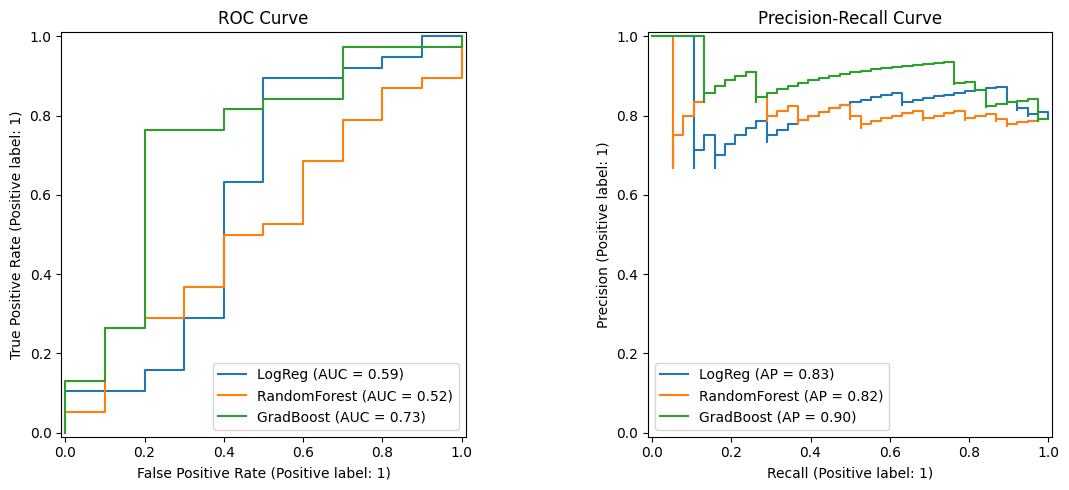

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ROC Curve (left)
RocCurveDisplay.from_predictions(
    y_test, proba_test_lr, name="LogReg", ax=axes[0]
)
RocCurveDisplay.from_predictions(
    y_test, proba_test_rf, name="RandomForest", ax=axes[0]
)
RocCurveDisplay.from_predictions(
    y_test, proba_test_gb, name="GradBoost", ax=axes[0]
)
axes[0].set_title("ROC Curve")

# Precision-Recall Curve (right)
PrecisionRecallDisplay.from_predictions(
    y_test, proba_test_lr, name="LogReg", ax=axes[1]
)
PrecisionRecallDisplay.from_predictions(
    y_test, proba_test_rf, name="RandomForest", ax=axes[1]
)
PrecisionRecallDisplay.from_predictions(
    y_test, proba_test_gb, name="GradBoost", ax=axes[1]
)
axes[1].set_title("Precision-Recall Curve")

plt.tight_layout()
plt.show()

### 10. Feature importance (tree-based)

Random Forest feature importance provides a quick view of what the model uses most.

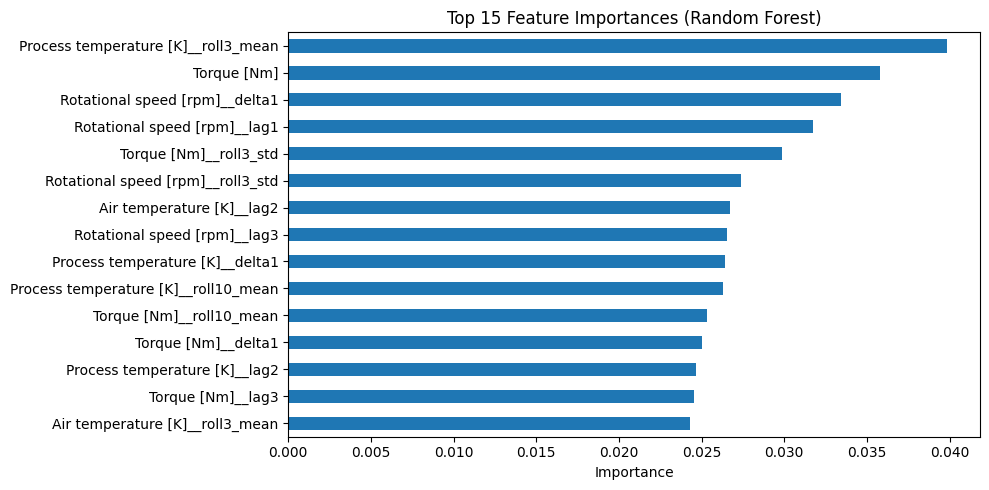

,importance
Process temperature [K]__roll3_mean,0.039847
Torque [Nm],0.035810
Rotational speed [rpm]__delta1,0.033444
Rotational speed [rpm]__lag1,0.031755
Torque [Nm]__roll3_std,0.029845
Rotational speed [rpm]__roll3_std,0.027405
Air temperature [K]__lag2,0.026741
Rotational speed [rpm]__lag3,0.026511
Process temperature [K]__delta1,0.026407
Process temperature [K]__roll10_mean,0.026291


In [10]:
importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
top_k = 15
top = importances.head(top_k)

plt.figure(figsize=(10,5))
top[::-1].plot(kind="barh")
plt.title(f"Top {top_k} Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

top.to_frame("importance")

### 11. Save model-ready artifacts

This saves the engineered time-series dataset used by Model 1 for reproducibility.

In [11]:
OUTPUT_FEATURES_PATH = "../data/ai4i_time_features_model1.csv"
df_feat.to_csv(OUTPUT_FEATURES_PATH, index=False)
print(f"Saved time-feature dataset to: {OUTPUT_FEATURES_PATH}")

Saved time-feature dataset to: ../data/ai4i_time_features_model1.csv


### 12. Export Classification Results for Tableau

In [15]:
os.makedirs("../outputs", exist_ok=True)

# Collect available probability vectors from this notebook
candidates = {}
if "proba_test_lr" in globals():
    candidates["LogReg"] = np.asarray(proba_test_lr)
if "proba_test_rf" in globals():
    candidates["RandomForest"] = np.asarray(proba_test_rf)
if "proba_test_gb" in globals():
    candidates["GradBoost"] = np.asarray(proba_test_gb)

if not candidates:
    raise NameError("No probability vectors found. Expected one of: proba_test_lr, proba_test_rf, proba_test_gb.")

# Pick best model by ROC-AUC on test set
scores = {name: roc_auc_score(y_test, proba) for name, proba in candidates.items()}
best_name = max(scores, key=scores.get)
y_pred_prob = candidates[best_name]

print("ROC-AUC by model:", {k: round(v, 4) for k, v in scores.items()})
print(f"Selected for export: {best_name}")

# Recommended threshold (Youden’s J)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
optimal_idx = (tpr - fpr).argmax()
recommended_threshold = float(thresholds[optimal_idx])
print(f"Recommended threshold (Youden's J): {recommended_threshold:.6f}")

# Pred label using recommended threshold
y_pred_label = (y_pred_prob >= recommended_threshold).astype(int)

# Use notebook's TIME_COL if available
time_col = TIME_COL if "TIME_COL" in globals() else "Tool wear [min]"
if time_col not in X_test.columns:
    raise KeyError(f"'{time_col}' not found in X_test columns: {list(X_test.columns)}")

export_df = pd.DataFrame({
    "tool_wear": X_test[time_col].values,
    "actual_failure": np.asarray(y_test).astype(int),
    "pred_prob_failure": y_pred_prob,
    "pred_label": y_pred_label,
    "model_selected": best_name,
    "recommended_threshold": recommended_threshold
}).sort_values("tool_wear")

export_path = "../outputs/pred_failure_traditional.csv"
export_df.to_csv(export_path, index=False)

print(f"Saved: {export_path} | rows={len(export_df)}")

ROC-AUC by model: {'LogReg': 0.5947, 'RandomForest': 0.5237, 'GradBoost': 0.7342}
Selected for export: GradBoost
Recommended threshold (Youden's J): 0.016185
Saved: ../outputs/pred_failure_traditional.csv | rows=48


### Why We Chose Failure Classification Instead of Torque Prediction

In an earlier draft, we considered predicting future torque values as a regression task. However, after reviewing the project objectives, we shifted to predicting **Machine failure (binary classification)** for the following reasons:

1. **Alignment with Project Goal**  
   The primary objective of predictive maintenance is to anticipate equipment failure, not merely forecast sensor values. Predicting failure directly better reflects real-world maintenance decision-making.

2. **Business Relevance**  
   Maintenance teams act on failure risk (fail vs. no-fail), not on small changes in torque. A classification model provides actionable outputs such as failure probability and risk thresholds.

3. **Clear Evaluation Metrics**  
   Failure classification allows the use of metrics suited for rare-event detection (ROC-AUC, Precision-Recall AUC), which are more appropriate for imbalanced industrial datasets.

4. **Avoiding Indirect Modeling**  
   Predicting torque and then inferring failure from torque changes adds an extra modeling step and potential error propagation. Directly modeling failure simplifies interpretation and reduces complexity.

For these reasons, we adopted a time-aware classification framework to predict machine failure using engineered temporal features derived from sensor data.